In [ ]:
import numpy as np
# Fixed parameters

# Initial Condition Input from the heat exchanger
T_H_in = 60
T_C_in = 20

# Fixed design parameters
di = 0.006             # fixed internal tube diameter
do = 0.008             # fixed outer tube diameter
d_noz = 0.02
d_pipe = 0.064
#d_bafcut = 0.25*d_pipe

# Thermo-Parameters:
rho_w = 990.1          #water density, kg/m^3
mu = 6.51*(10**(-4))   #friction coefficient
C_p = 4179             #heat capacity for water, J/kgK
k_w = 0.632            #lambda, W/mK
k_tube = 386           #W/mK
Pr = 4.31

In [ ]:
# Design Choices
m_dot_H = 0.2             # maximum mass flow rate is 2 kg/s
m_dot_C = 0.5
Nt = 2                   # number of tube pass
Ns = 1                 # number of shell pass
N = 12                    # Number of copper tubes
#L_tot = 3.5
#L = (L_tot/N + 0.07)     # Length of the each pass of copper tubes
#if L < 0.35:
#   L = L
#else:
#  L = 0.35
L = 0.346
#print('Tube length = ', L-0.07)
Y = 0.012                   # tube pitch, perpendicular spacing
Nb =8                # number of baffles
#B = (L-0.07-0.04*Ns)/(Nb+1)                   # baffle spacing
L_tube = 0.278
#B = L_tube / (Nb-1)
B = 0.25
alpha = (Nb-6)/(27-6)

tube_bunddle = 'triangular'      #triangular/square

# Quantities related to Design Parameters
A_tube = (np.pi/4)*(di**2)         # copper tube
A_noz = (np.pi/4)*(d_noz**2)       # inlet and outlet nozzel
A_pipe = ((np.pi/4)*(d_pipe**2))/Ns     # plastic transperant shell tube
if Ns == 1:
  d_pipe = d_pipe
if Ns == 2:
  d_pipe = (d_pipe/2)*np.sqrt(3)
A_sh = ((d_pipe)*B*((Y-do)/Y))          # Effective Flow area for each shell pass



In [ ]:
# Hydraulic Analysis

## Hot stream
def calc_m_dot(m_dot_H, m_dot_C):
  # Velocity in the tube
  m_dot_tube = m_dot_H / (N/Nt)                            # mass flow in each tube of each tube pass
  v_tube = m_dot_tube / (rho_w * A_tube)

  # Reynolds Number of flow in tube
  Re_tube = (rho_w * v_tube * di) / mu

  # Nozzel Velocity
  v_noz_H = m_dot_H/ (rho_w * A_noz)

  # Pressure Drop in tubes related to friction
  f = (1.82 * np.log10(Re_tube) - 1.64)**(-2)
  #sigma = (N/Nt) * A_tube / A_pipe
  #print('sigma = ', sigma)
  #print('Re = ', Re_tube)

  # Read kc ke manually
  Kc = 0.45
  Ke = 0.75

  # Pressure Drop in tubes related to friction
  del_p_tube = 0.5 * rho_w * ((v_tube)**2)*f*(L*Nt)/di

  #Pressure Drop in tube ends
  del_p_ends = 0.5 * rho_w * ((v_tube)**2)*(Kc+Ke)

  #Pressure Drop in nozzle
  del_p_noz_H = rho_w * ((v_noz_H)**2)

  del_p_tot_H = round(((del_p_tube + del_p_ends + del_p_noz_H) / (10**5)) , 4)


  ## Cold stream
  # Velocity of flow in shell
  v_sh = m_dot_C/ (rho_w * A_sh)

  # Characteristic Length scale for the shell flow
  d_sh_dash = d_pipe * (A_sh/A_pipe)

  # Reynolds Number of flow in shell
  Re_sh = rho_w * v_sh * d_sh_dash / mu

  #Pressure drop in the shell
  if tube_bunddle == 'triangular':
    a = 0.2
    c = 0.2
  else:
    a = 0.34
    c = 0.15

  del_p_sh = 4 * a * (Re_sh**(-0.15)) * (N/Ns) *rho_w * (v_sh**2)

  #nozzle velocity
  v_noz_C = m_dot_C/ (rho_w * A_noz)
  #Pressure Drop in nozzle
  del_p_noz_C = rho_w * ((v_noz_C)**2)
  # Baffle pressure drop
  del_p_baf = 2*(0.5 * rho_w * (v_sh**2)* Nb)* alpha     # alpha * 2 * 0.5rhov**2, 0<alpha<1, alpha =1 if close baffles, here alpha = 0.5
                                                       # Test factor of 3.5 for baffle pressure drop
  del_p_tot_C = round(((del_p_sh + del_p_noz_C + del_p_baf) / (10**5)) , 4)


  # Compressor data read manually
  # get average value of mass flow rate

  m_dot_chart_C = (0.3739 - np.sqrt((0.3739**2) - 4*(-0.5237)*((0.6579-0.131)-del_p_tot_C)))/(2*(-0.5237))      # litre/s
  m_dot_chart_H = (0.6777 - np.sqrt((0.6777**2) - 4*(-0.8204)*((0.5626-0.0538)-del_p_tot_H)))/(2*(-0.8204))      # litre/s

  #print('Trail Values: ','m_dot_H=',"%.2g" % m_dot_H, 'm_dot_C=',"%.2g" % m_dot_C)

  m_dot_H = (m_dot_chart_H*0.001*rho_w + m_dot_H)/2
  m_dot_C = (m_dot_chart_C*0.001*rho_w + m_dot_C)/2

  #print('New Values:   ','m_dot_H=',"%.2g" % m_dot_H,'m_dot_C=', "%.2g" % m_dot_C)
  return m_dot_H, m_dot_C, del_p_tot_H, del_p_tot_C


del_mdot_H = 10
del_mdot_C = 10
counter = 0

while np.abs(del_mdot_H) > 0.001 or np.abs(del_mdot_C) > 0.001:
  if counter < 30:
    m_dot_H_2 = calc_m_dot(m_dot_H, m_dot_C)[0]
    m_dot_C_2 = calc_m_dot(m_dot_H, m_dot_C)[1]
    del_mdot_H = m_dot_H - m_dot_H_2
    del_mdot_C = m_dot_C - m_dot_C_2
    m_dot_H = m_dot_H_2
    m_dot_C = m_dot_C_2
    counter += 1
  else:
    print('Runtime Error')
    break
else:

  del_p_tot_H = calc_m_dot(m_dot_H, m_dot_C)[2]+0.0538
  del_p_tot_C = calc_m_dot(m_dot_H, m_dot_C)[3]+0.131

  del_p_tot_H=del_p_tot_H                               #test for sensitivity in change in del_p
  m_dot_H = (0.6777 - np.sqrt((0.6777**2) - 4*(-0.8204)*((0.5626-0.0538)-del_p_tot_H)))/(2*(-0.8204))

  del_p_tot_C=del_p_tot_C+0.02
  m_dot_C = (0.3739 - np.sqrt((0.3739**2) - 4*(-0.5237)*((0.6579-0.131)-del_p_tot_C)))/(2*(-0.5237))

  print('m_dot_C =  ', m_dot_C/(0.001*rho_w), 'Litre/s')
  print('m_dot_H =  ', m_dot_H/(0.001*rho_w), 'Litre/s')
  print('Del_P_Cold = ', del_p_tot_C)
  print('Del_P_Hot = ',del_p_tot_H)






m_dot_C =   0.5196441396364944 Litre/s
m_dot_H =   0.34889240339549193 Litre/s
Del_P_Cold =  0.1959
Del_P_Hot =  0.1768


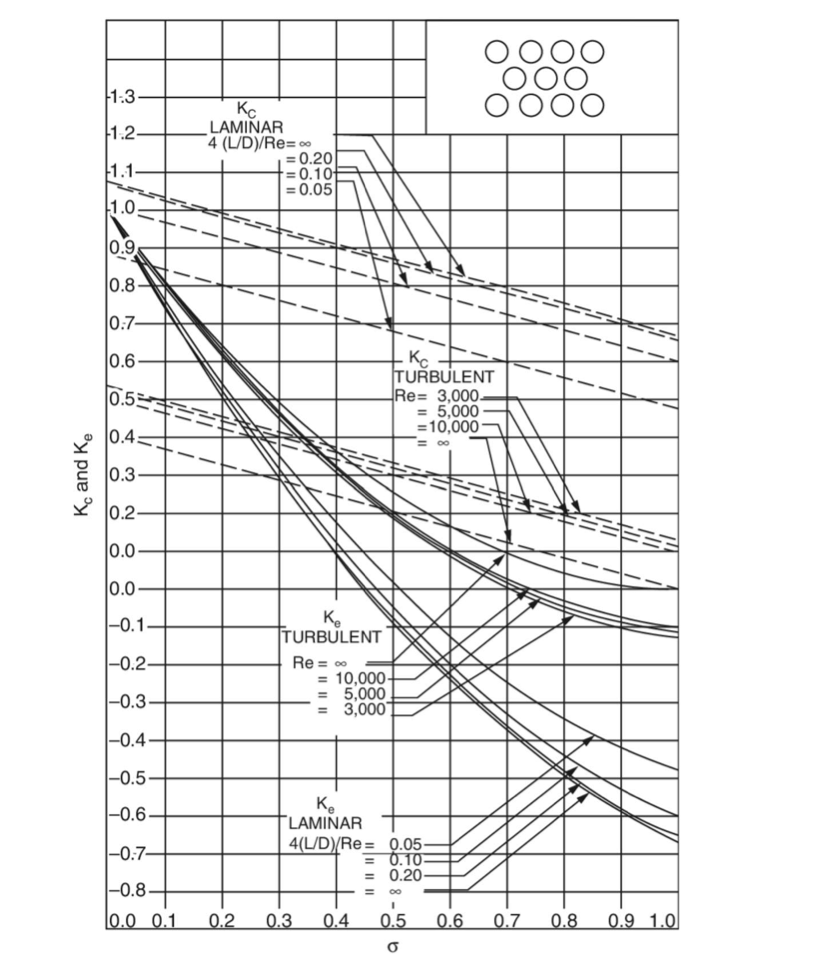

In [ ]:
## Hot stream
# Velocity in the tube
m_dot_tube = m_dot_H / (N/Nt)                            # mass flow in each tube of each tube pass
v_tube = m_dot_tube / (rho_w * A_tube)

# Reynolds Number of flow in tube
Re_tube = (rho_w * v_tube * di) / mu

## Cold stream
# Velocity of flow in shell
v_sh = m_dot_C/ (rho_w * A_sh)

# Characteristic Length scale for the shell flow
d_sh_dash = d_pipe * (A_sh/A_pipe)

# Reynolds Number of flow in shell
Re_sh = rho_w * v_sh * d_sh_dash / mu

  #Pressure drop in the shell
if tube_bunddle == 'triangular':
  a = 0.2
  c = 0.2
else:
  a = 0.34
  c = 0.15

In [ ]:
# Thermal Analysis
# LMTD Method

# Nusselt number based on inner tube diameter
Nu_i = 0.023 * (Re_tube**0.8) * (Pr**0.3)
# Outer heat transfer coefficient
Nu_o = c * (Re_sh**0.6) * (Pr**0.3)

# Heat convection coefficients
h_i = (Nu_i * k_w)/di
h_o = (Nu_o * k_w)/do

# Overall heart transfer coefficient H
H = 1/((1/h_i) + ((np.pi*di* L*Nt *np.log(do/di))/(2*np.pi*k_tube * (L*Nt))) + (di/do)/h_o)
A = (N/Nt) * np.pi * di * (L * Nt)      # Outer surface area for the tubes
#print(Nu_i, Nu_o,h_i,h_o,H)
# Iteration Initiation:
T_C_out = 31.4              # Arbitary Value

def calc_F(T_H_in, T_C_in, T_C_out):
  T_H_out = T_H_in - (m_dot_C/m_dot_H)*(T_C_out - T_C_in)
  P = (T_C_out - T_C_in)/(T_H_in - T_C_in)
  R = (T_H_in - T_H_out)/ (T_C_out - T_C_in)
  S = ((R**2 + 1)**0.5) / (R - 1)
  W = ((1 - P*R)/(1 - P))**(1/Ns)
  F = S* np.log(W)/ np.log(( 1 + W - S + S * W) /( 1 + W + S - S * W))
  #https://cheguide.com/lmtd_charts.html#google_vignette, where the correlation of F from
  return F

def cal_del_T_lm(T_H_in, T_C_in, T_C_out):
  T_H_out = T_H_in - (m_dot_C/m_dot_H)*(T_C_out - T_C_in)
  del_T_lm = ((T_H_in - T_C_out) - (T_H_out - T_C_in))/np.log((T_H_in - T_C_out)/(T_H_out - T_C_in))
  return del_T_lm


def LMTD(T_C_out):
  T_H_out = T_H_in - (m_dot_C/m_dot_H)*(T_C_out - T_C_in)

  del_T_lm = cal_del_T_lm(T_H_in, T_C_in, T_C_out)

  F = calc_F(T_H_in, T_C_out, T_C_in)

# Iteration Start

  T_C_out_2 = T_C_in + H * A * del_T_lm * F / (m_dot_C*C_p)
  return T_C_out_2

del_T_C_out = 10

while np.abs(del_T_C_out) > 0.01:
  T_C_out_2 = LMTD(T_C_out)
  del_T_C_out = T_C_out - T_C_out_2
  T_C_out = T_C_out_2
else:
  print('T_C_out = ', T_C_out)
  print('T_H_out = ', T_H_in - (m_dot_C/m_dot_H)*(T_C_out - T_C_in))

# Effectiveness
F = calc_F(T_H_in, T_C_in, T_C_out)
Q_dot = H * A * cal_del_T_lm(T_H_in, T_C_in, T_C_out) * calc_F(T_H_in, T_C_in, T_C_out)
Q_dot_max = m_dot_H * C_p * (T_H_in - T_C_in)
e_LMTD = Q_dot/Q_dot_max
print('The effectiveness of the heat exchanger is', e_LMTD)
print('Q dot = ', Q_dot/1000, 'kW')

T_C_out =  25.988531735593792
T_H_out =  51.08061571091035
The effectiveness of the heat exchanger is 0.2222023422905062
Q dot =  12.830735995937411 kW


In [ ]:
#NTU method

# Calcualting C_min #m_dot_H<m_dot_C
C_min = min(C_p * m_dot_H, C_p*m_dot_C)
C_max = max(C_p * m_dot_H, C_p*m_dot_C)

# Calcualting F. (Do we need F for NTU method?)
#F = calc_F(T_H_in, T_C_out, T_C_in)

# Finding NTU value for each shell pass
NTU = (H * (A/Ns))/C_min

# Finding Capacity Ratio
Cr = C_min/C_max

#Finding effectiveness for counter-flow heat exchanger
# https://en.wikipedia.org/wiki/NTU_method#:~:text=The%20effectiveness%2DNTU%20method%20is,equation%20for%20LMTD%20or%20effectiveness.

e_NTU_each = 2*(1+Cr+(1+Cr**2)**(1/2)*(1+np.exp(-NTU*((1+Cr**2)**(1/2))))/(1-np.exp(-NTU*((1+Cr**2)**(1/2)))))**(-1)

if Ns == 1:
  e_NTU = e_NTU_each
  print('1 shell pass')
elif Ns == 2:
  ep = e_NTU_each
  e_NTU = (((1-ep*Cr)/(1-ep))**(Ns)-1)/(((1-ep*Cr)/(1-ep))**(Ns)-Cr)
  print('2 shell pass')

print('The effectiveness of the heat exchanger is', e_NTU)




1 shell pass
The effectiveness of the heat exchanger is 0.22235927761502905


In [ ]:
# Assert Total Weight
M_tube = N*L_tube*0.2
M_pipe = (L) * 0.65
M_noz = 4*0.025
M_baf = Nb*((A_pipe*Ns)*0.8- N*(A_tube))*2.39
M_splitter = (d_pipe*0.03)*2.39
M_end = ((2*A_pipe*Ns)*0.003)*1150
M_tubesheet = 2*((A_pipe*Ns)- N*(A_tube))*0.0045*1150
M_tot = (M_tube + M_pipe + M_noz + M_baf + M_end + M_splitter + M_tubesheet)
print(M_tot)
print(M_tube, M_pipe, M_baf, M_noz, M_end)

1.0913900496576838
0.6672000000000001 0.2249 0.04271982929285613 0.1 0.02219723705320404
